# CA05-A-Logistic_Regression

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import seaborn as sns

## Load Data and Build the Model

In [2]:
df = pd.read_csv('https://github.com/ArinB/CA05-B-Logistic-Regression/raw/master/cvd_data.csv')
df.head()

,cvd_4types,age_s1,race,educat,mstat,hip,neck20,waist,av_weight_kg,cgpkyr,tea15,srhype,parrptdiab,bend25,happy25,tired25,hlthlm25
0,0,54,1,2,1,110.0,40.0,108.0,87.5,34.0,0,1,0,1,2,3,4
1,0,56,3,2,1,113.0,34.0,107.0,83.5,0.0,0,0,0,2,2,1,3
2,0,54,1,3,1,110.0,44.5,105.0,86.2,49.5,0,0,0,3,2,6,4
3,0,54,1,3,1,129.0,42.5,110.0,89.1,0.0,0,0,0,3,2,1,3
4,0,51,3,2,1,122.0,37.0,113.0,81.3,0.0,0,0,0,2,1,1,2


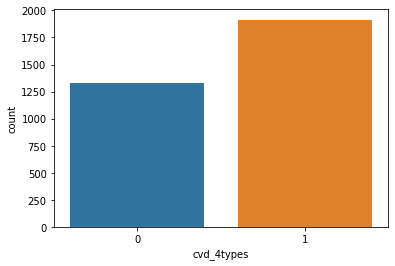

In [9]:
# See if we got an imbalanced data
sns.countplot(df['cvd_4types'])

In [3]:
# normalized the data because the scals for different columns are not the same
min_max_scaler = preprocessing.MinMaxScaler()

In [4]:
# the normalized value would be stored in numpyarray
scaled_array = min_max_scaler.fit_transform(df.drop('cvd_4types',axis=1))

In [5]:
# Split the data set by specify the size as 0.3
X_train, X_test, y_train, y_test = train_test_split(scaled_array, df['cvd_4types'], test_size=0.3, random_state=42)

### Train the model without specify the hyperparameters

In [6]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
acc = accuracy_score(y_test, y_pred)
acc

C:\Users\wuuj0\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6649537512846866

### Use GridSearch to find the best hyperparameter

In [7]:
# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create penalty and solver space
solver = ['sag','lbfgs','newton-cg']

# Create hyperparameter options
random_state = [42]
hyperparameters = dict(C=C, solver=solver, random_state=random_state)

In [8]:
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(lr, hyperparameters, cv=5)

In [9]:
best_model = clf.fit(X_train, y_train)

In [10]:
# View best hyperparameters
print('Best Solver:', best_model.best_estimator_.get_params()['solver'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Solver: sag
Best C: 166.81005372000593


### Re-train the model

In [11]:
lr = LogisticRegression(C=166.8, solver='sag', random_state=42)
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
acc = accuracy_score(y_test, y_pred)
# The accuracy did increase, but it isn't significant
acc

0.6700924974306269

### Feature Importance

In [13]:
stand_coef = np.std(X_train,0)*lr.coef_[0]
print(stand_coef)

[-0.02105181 -0.4312942   0.14851656 -0.13014033 -0.60732548 -0.16656379
  1.12147296 -0.20137126 -0.03242141 -0.10526132  0.0542356   0.13791629
  0.04502588 -0.06757933  0.16091297 -0.44502318]


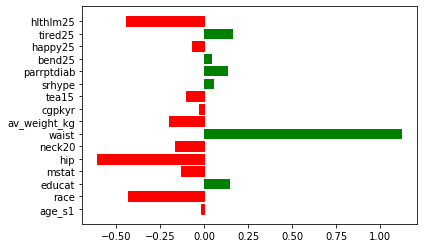

In [18]:
barlist = plt.barh(list(df.drop('cvd_4types',axis=1).columns),stand_coef,color='g')
for i,coef in enumerate(lr.coef_[0]):
    if coef<0:
        barlist[i].set_color('r')
    else: pass
# The green factors would increase the probability of being 1 and vice versa

### Model Evaluation

In [39]:
y_score = lr.predict_proba(X_test)[:,1]

Text(0, 0.5, 'True Positive Rate')

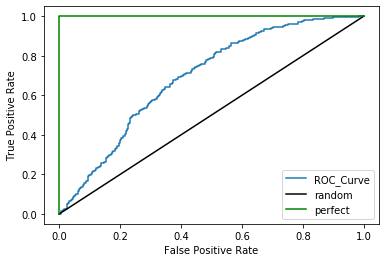

In [40]:
fp, tp, threshold = roc_curve(y_test, y_score)
plt.plot(fp, tp,label = 'ROC_Curve')
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# The ROC curve is only a little bit better than the random line

In [41]:
auc_lr = roc_auc_score(y_test, y_score)
print("The AUC for the Logistic Regression is {}".format(round(auc_lr,4)))

The AUC for the Logistic Regression is 0.691


# CA05-B-KNN

In [19]:
from sklearn.neighbors import NearestNeighbors

In [20]:
movie = pd.read_csv('https://github.com/ArinB/CA05-kNN/raw/master/movies_recommendation_data.csv')
movie.head()

,Movie ID,Movie Name,IMDB Rating,Biography,Drama,Thriller,Comedy,Crime,Mystery,History,Label
0,58,The Imitation Game,8.0,1,1,1,0,0,0,0,0
1,8,Ex Machina,7.7,0,1,0,0,0,1,0,0
2,46,A Beautiful Mind,8.2,1,1,0,0,0,0,0,0
3,62,Good Will Hunting,8.3,0,1,0,0,0,0,0,0
4,97,Forrest Gump,8.8,0,1,0,0,0,0,0,0


In [21]:
# get rid of unnecessary columns without destroying the original structure
df = movie.copy()
df.drop(['Movie ID', 'Movie Name', 'Label'], axis = 1,inplace = True)

### Build the recommendation and show the result

In [22]:
# The goal is to recommend five similiar movie, so the n_neighbors is 5
nbrs = NearestNeighbors(n_neighbors=5, algorithm='kd_tree').fit(df)

# Next we find k nearest neighbor for each point in df.
distances, indices = nbrs.kneighbors(df)

In [23]:
print(indices[:10])
# The first number in each array is their index
# Start from the second number would be their nearest neighbers' indices respectively

[[ 0  2 16 29 28]
 [ 1  6 21 18 10]
 [ 2 16 29 27 28]
 [ 3 12  4  6 18]
 [ 4 12  3 15 17]
 [ 5 10  9 21 18]
 [ 6 18 21 10  9]
 [ 7 20 10  9 18]
 [ 8 22 24 14 19]
 [ 9 10 18 21  6]]


In [25]:
# the function that could show 4 recommendations for each movie
def all_recommend(movie_df):
    mov_series = movie_df['Movie Name']
    whole_recommend = []
    for single_movie in indices:
        recomm_movie = []
        for recommend_indices in single_movie:
            movie_name = mov_series.iloc[recommend_indices]
            recomm_movie.append(movie_name)
        whole_recommend.append(recomm_movie)
    movie_dict = {}
    for movie_i in whole_recommend:
        movie = movie_i[0]
        recommendation = movie_i[1:]
        movie_dict[movie] = recommendation
    recommend_df = pd.DataFrame(movie_dict).transpose().rename(columns={0:'1st recommendation',1:'2nd recommendation',
                                                         2:'3rd recommendation',3:'4th recommendation'})
    return recommend_df

In [28]:
all_recommend(movie).head(10)

,1st recommendation,2nd recommendation,3rd recommendation,4th recommendation
The Imitation Game,A Beautiful Mind,The Wind Rises,Queen of Katwe,12 Years a Slave
Ex Machina,Gifted,Stand and Deliver,Finding Forrester,A Brilliant Young Mind
A Beautiful Mind,The Wind Rises,Queen of Katwe,Hacksaw Ridge,12 Years a Slave
Good Will Hunting,Interstellar,Forrest Gump,Gifted,Finding Forrester
Forrest Gump,Interstellar,Good Will Hunting,Inception,Spirited Away
21,A Brilliant Young Mind,The Karate Kid,Stand and Deliver,Finding Forrester
Gifted,Finding Forrester,Stand and Deliver,A Brilliant Young Mind,The Karate Kid
Travelling Salesman,The DaVinci Code,A Brilliant Young Mind,The Karate Kid,Finding Forrester
Avatar,The Terminator,The Avengers,Black Panther,The Fountain
The Karate Kid,A Brilliant Young Mind,Finding Forrester,Stand and Deliver,Gifted


In [312]:
# This function could allow you to search movies' recommendation
def search_recommend(movie_name):
    df = all_recommend(movie)
    return df.loc[movie_name,:]

In [317]:
search_recommend(['The Imitation Game','Ex Machina'])

,1st recommendation,2nd recommendation,3rd recommendation,4th recommendation
The Imitation Game,A Beautiful Mind,The Wind Rises,Queen of Katwe,12 Years a Slave
Ex Machina,Gifted,Stand and Deliver,Finding Forrester,A Brilliant Young Mind


### Recommendation for "The Post"

In [164]:
the_post = [7.2, 1, 1, 0, 0, 0, 0, 1]
distances_n, indices_n = nbrs.kneighbors([the_post])
print(indices_n)
# These are the five most nearest movies' indices
# Different from the indices above that start from the second number
# "The Post" is a new record that hasn't been trained in the fitted model
# Therefore, the first number is the 1st recommendation in the model instead of its index

[[28 27 29 16  2]]


In [260]:
def get_recommend(movie_feature_vector):       
    mov_series = movie['Movie Name']
    distances_n, indices_n = nbrs.kneighbors([movie_feature_vector])
    recommend_movie = []
    for i in indices_n[0]:
        movie_name = mov_series.iloc[i]
        recommend_movie.append(movie_name)
    return recommend_movie

In [269]:
get_recommend(the_post)

['12 Years a Slave',
 'Hacksaw Ridge',
 'Queen of Katwe',
 'The Wind Rises',
 'A Beautiful Mind']

In [268]:
for i,movie_n in enumerate(get_recommend(the_post)):
    # make i = i+1 so the i could start from 1 instead of 0
    i+=1
    print('The {} recommendation is {}'.format(i,movie_n))


The 1 recommendation is 12 Years a Slave
The 2 recommendation is Hacksaw Ridge
The 3 recommendation is Queen of Katwe
The 4 recommendation is The Wind Rises
The 5 recommendation is A Beautiful Mind
